In [1]:
# from aerobot.plot import plot_training_curve
import os
from aerobot.utils import load_results_dict, RESULTS_PATH, FEATURE_TYPES, FIGURES_PATH
import matplotlib.pyplot as plt
from aerobot.plot import plot_configure_mpl, plot_model_accuracy_barplot, plot_order_feature_types, plot_percent_above_random_axis
from aerobot.plot import PRETTY_NAMES
from matplotlib.gridspec import GridSpec
# from aerobot.dataset import dataset_load_training_validation
import pandas as pd 
import numpy as np 
from typing import Dict, List

%load_ext autoreload
%autoreload 2

plot_configure_mpl(figure_height=6)

In [2]:

runtime_df = pd.read_csv(os.path.join(RESULTS_PATH, 'runtimes.csv'), index_col=0)
mean_time = runtime_df.groupby('feature_type').elapsed_time.mean()
std_time = runtime_df.groupby('feature_type').elapsed_time.std()

# make a single DF and write to latex
runtime_summary_df = pd.DataFrame({'mean runtime (s)': mean_time, 'standard deviation': std_time})
runtime_summary_df.to_latex(os.path.join(RESULTS_PATH, 'runtime_summary.tex'), float_format="%.2f")


In [3]:
# Load the model training results. 
nonlinear_results_ternary = dict()
logistic_results_ternary = dict()
logistic_results_binary = dict()

for feature_type in FEATURE_TYPES:
    nonlinear_results_ternary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_nonlinear_{feature_type}_ternary.json'))
    logistic_results_ternary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_logistic_{feature_type}_ternary.json'))
    logistic_results_binary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_logistic_{feature_type}_binary.json'))

for results_type, results in zip(['Nonlinear ternary', 'Logistic binary', 'Logistic ternary'], [nonlinear_results_ternary, logistic_results_ternary, logistic_results_binary]):
    print(results_type, 'results')
    order_by = {f:r['test_acc'] for f, r in results.items()}
    feature_order = sorted(order_by, key=order_by.get, reverse=True)
    for feature_type in feature_order:
        feature_type_results = results[feature_type]
        test_acc = feature_type_results['test_acc']
        train_acc = feature_type_results['train_acc']
        print(f'\t{feature_type}:', f'test_acc={test_acc}, train_acc={train_acc}')

    print()

Nonlinear ternary results
	embedding_oxygen_genes: test_acc=0.8505705986728103, train_acc=0.9159732035912276
	embedding_genome: test_acc=0.8473144368974199, train_acc=0.8961207743567718
	aa_2mer: test_acc=0.842493937752051, train_acc=0.9265796222283229
	ko: test_acc=0.8365164735183231, train_acc=0.9828538690306123
	aa_3mer: test_acc=0.8150330727260271, train_acc=0.9827765108262
	cds_4mer: test_acc=0.7849720794062479, train_acc=0.8858346672258391
	cds_5mer: test_acc=0.7809644565151542, train_acc=0.8883896096131848
	cds_3mer: test_acc=0.7745746801573269, train_acc=0.8270665642107694
	nt_4mer: test_acc=0.7731415664407089, train_acc=0.902757967769039
	aa_1mer: test_acc=0.7403560293252575, train_acc=0.7692829060180376
	nt_3mer: test_acc=0.7172351280304871, train_acc=0.7899312091651746
	ko_terminal_oxidase_genes: test_acc=0.6908748943388258, train_acc=0.6887422848193602
	cds_2mer: test_acc=0.6495000167019673, train_acc=0.6704695269543891
	percent_oxygen_genes: test_acc=0.6439926137672901, tr

In [4]:
# Generate a latex table of the results for the supplementary material.
latex_table = pd.DataFrame()
order_by = {f:r['test_acc'] for f, r in nonlinear_results_ternary.items()}
feature_order = sorted(order_by, key=order_by.get, reverse=True)
pretty_feature_order = [PRETTY_NAMES[f] for f in feature_order]

names = ['nonlinear ternary', 'logistic ternary', 'logistic binary']
result_dicts = [nonlinear_results_ternary, logistic_results_ternary, logistic_results_binary]
latex_table['feature type'] = pretty_feature_order
latex_table.set_index('feature type', inplace=True)

for results_type, results in zip(names, result_dicts):
    for feature_type in feature_order:
        feature_type_results = results[feature_type]
        val_acc = feature_type_results['test_acc']
        train_acc = feature_type_results['train_acc']
        latex_table.at[PRETTY_NAMES[feature_type], results_type] = f'{val_acc:.2f} ({train_acc:.2f})'

latex_fname = os.path.join(RESULTS_PATH, 'feature_type_results_table.tex')
latex_table.to_latex(latex_fname, escape=False)


# SI Figure 2 



In [5]:
def plot_si_figure_2a(logistic_results_binary:Dict, order_by:Dict, grid:GridSpec=None, fig:plt.Figure=None):  
    '''Plots a barplot showing the final training and validation accuracies of the binary Logistic classifier.'''
    ax = fig.add_subplot(grid)
    
    ax.set_title('logistic binary classifier')
    plot_percent_above_random_axis(ax, binary=True)

    feature_type_order = plot_order_feature_types(list(logistic_results_binary.keys()), order_by=order_by)
    
    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(logistic_results_binary, ax=ax, feature_type_order=feature_type_order)

    return ax

In [6]:
def plot_si_figure_2b(logistic_results_ternary:Dict, order_by:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plots a barplot showing the final training and validation accuracies of the ternary Logistic classifier.'''
    ax = fig.add_subplot(grid)

    ax.set_title('logistic ternary classifier')
    plot_percent_above_random_axis(ax, binary=False)

    feature_type_order = plot_order_feature_types(list(logistic_results_ternary.keys()), order_by=order_by)
    
    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(logistic_results_ternary, ax=ax, feature_type_order=feature_type_order)

    return ax

In [7]:
def plot_si_figure_2c(nonlinear_results_ternary:Dict, order_by:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plots a barplot showing the final training and validation accuracies of the ternary Nonlinear classifier.'''
    ax = fig.add_subplot(grid)

    ax.set_title('nonlinear ternary classifier')
    plot_percent_above_random_axis(ax, binary=False)

    feature_type_order = plot_order_feature_types(list(nonlinear_results_ternary.keys()), order_by=order_by)
    
    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(nonlinear_results_ternary, ax=ax, feature_type_order=feature_type_order)
    
    return ax

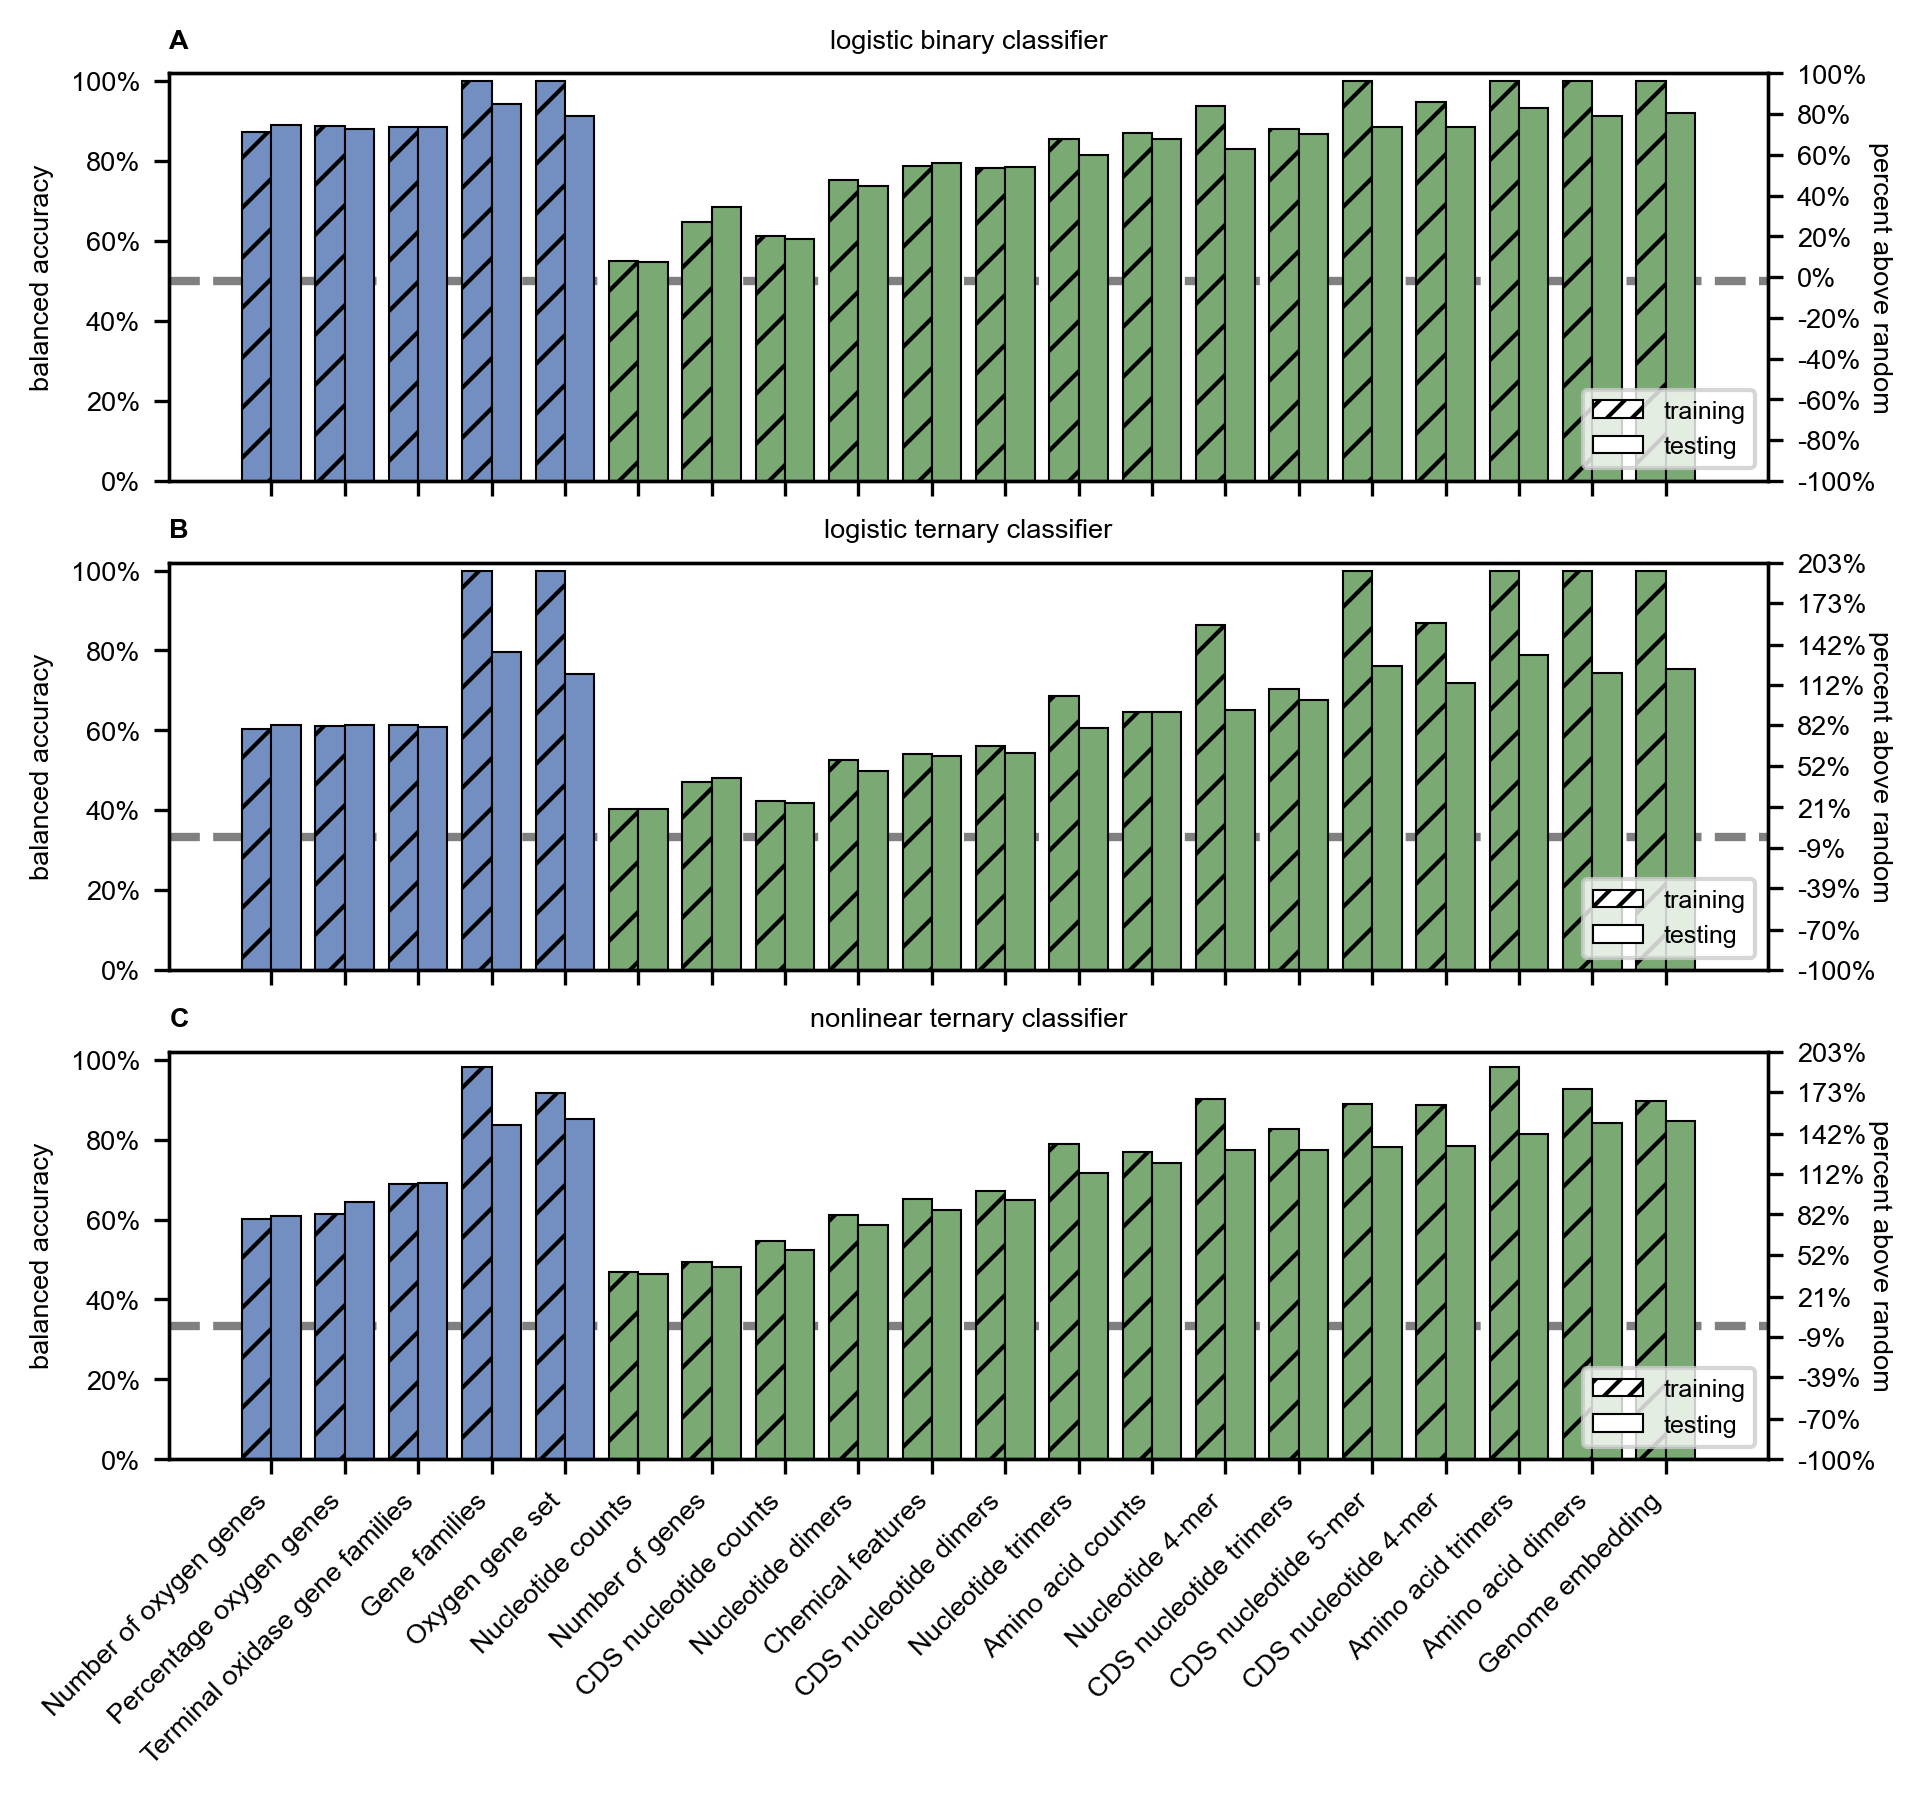

In [8]:
#fig = plt.figure(figsize=(15, 3))
fig = plt.figure()
grid = GridSpec(3, 1, wspace=0.25, )

axes = []

# Enforce same order for all the plots
order_by = {f:r['test_acc'] for f, r in nonlinear_results_ternary.items()}
axes.append(plot_si_figure_2a(logistic_results_binary, order_by, grid=grid[0, 0], fig=fig))
axes.append(plot_si_figure_2b(logistic_results_ternary, order_by, grid=grid[1, 0], fig=fig))
axes.append(plot_si_figure_2c(nonlinear_results_ternary, order_by, grid=grid[2, 0], fig=fig))

for ax, ax_label in zip(axes, 'ABC'):
    ax.set_title(ax_label, loc='left', fontweight='bold')
    if ax != axes[-1]:
        ax.set_xlabel('')
        ax.set_xticklabels([])

plt.savefig(os.path.join(FIGURES_PATH, 'si_fig2.png'), dpi=300, facecolor='w', bbox_inches='tight')
plt.show()
